In [1]:
import sys
sys.path.append("../src")
import matplotlib.pyplot as plt
import generate_general_networks as generate
import torch
import numpy as np
import tikzplotlib
import FV_schemes as fv


#### Single lane network

We start by computing the partial derivative using AD

In [2]:
# Create network and run simulation
T = 60
N = 3
speed_limit = [torch.tensor(40.0)]
controls = []

network = generate.single_lane_network(T, N, speed_limit, controls, track_grad=True)
densities, queues, lengths, delays, n_stops = network.solve_cons_law_counting()

Bus bus_1 reached bus stop 0 at time 25.714275360107422, should wait for 29.915130615234375 seconds


In [3]:
def throughput(network, densities):
    flux_out = torch.tensor(0.0)
    times = list(densities[0].keys())
    for i, road in enumerate(network.roads):
        if not road.right:
            # Outgoing road
            for k in range(len(times)-1):
                t1 = times[k]
                t2 = times[k+1]
                # Find density at the end of the road
                end_rho1 = densities[i][t1][-1]
                end_rho2 = densities[i][t2][-1]

                flux1 =  fv.flux(end_rho1, road.gamma[0])
                flux2 =  fv.flux(end_rho2, road.gamma[0])

                flux_out -= (t2 - t1) * (flux1 + flux2) / 2
    return flux_out

In [4]:
# Compute gradient
objective_val = throughput(network, densities)
objective_val.backward()

speed_grad = network.get_speed_limit_grads()
light_grad = network.get_traffic_light_grads()

In [5]:
print(speed_grad[0]/3.6)

-0.034682903852727674


Now we estimate the same gradient using finite differences

In [6]:
# Forward difference
h_list = [20, 10, 5, 2, 1, 0.5, 0.2, 0.1]
objectives_fwd = []
for h in h_list:
    speed_limit_h = [torch.tensor(40.0 + h)]
    network_h = generate.single_lane_network(T, N, speed_limit_h, controls, track_grad=False)
    densities_h, _, _, _, _ = network_h.solve_cons_law_counting()
    objectives_fwd.append(throughput(network_h, densities_h))

objectives_bwd = []
for h in h_list:
    speed_limit_h = [torch.tensor(40.0 - h)]
    network_h = generate.single_lane_network(T, N, speed_limit_h, controls, track_grad=False)
    densities_h, _, _, _, _ = network_h.solve_cons_law_counting()
    objectives_bwd.append(throughput(network_h, densities_h))

Bus bus_1 reached bus stop 0 at time 17.142864227294922, should wait for 29.94342041015625 seconds
Bus bus_1 reached bus stop 0 at time 20.571435928344727, should wait for 29.932104110717773 seconds
Bus bus_1 reached bus stop 0 at time 22.857131958007812, should wait for 29.924558639526367 seconds
Bus bus_1 reached bus stop 0 at time 24.48978614807129, should wait for 29.919170379638672 seconds
Bus bus_1 reached bus stop 0 at time 25.08711051940918, should wait for 29.917200088500977 seconds
Bus bus_1 reached bus stop 0 at time 25.396818161010742, should wait for 29.91617774963379 seconds
Bus bus_1 reached bus stop 0 at time 25.586339950561523, should wait for 29.915552139282227 seconds
Bus bus_1 reached bus stop 0 at time 25.650175094604492, should wait for 29.915340423583984 seconds
Bus bus_1 reached bus stop 0 at time 51.428550720214844, should wait for 29.830259323120117 seconds
Bus bus_1 reached bus stop 0 at time 34.285728454589844, should wait for 29.886838912963867 seconds
Bus 

In [7]:
derivatives_fwd = []
for h, objective in zip(h_list, objectives_fwd):
    derivatives_fwd.append((objective - objective_val.detach()) / h)

derivatives_bwd = []
for h, objective in zip(h_list, objectives_bwd):
    derivatives_bwd.append((objective_val.detach() - objective) / h)

In [8]:
derivatives_fwd

[tensor(-0.0486),
 tensor(-0.0435),
 tensor(-0.0378),
 tensor(-0.0345),
 tensor(-0.0350),
 tensor(-0.0364),
 tensor(-0.0346),
 tensor(-0.0348)]

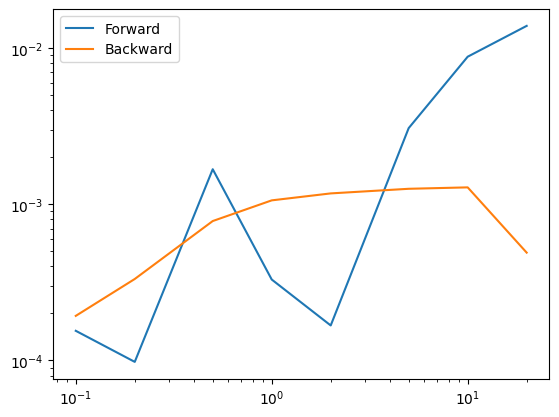

In [9]:
errors_fwd = [abs(deriv - speed_grad[0]/3.6) for deriv in derivatives_fwd]
errors_bwd = [abs(deriv - speed_grad[0]/3.6) for deriv in derivatives_bwd]

plt.loglog(h_list, errors_fwd, label="Forward")
plt.loglog(h_list, errors_bwd, label="Backward")
plt.legend()
plt.show()

Finite difference approximation of derivative seem to converge, although the convergence is a bit unstable

#### Single Junction

We now consider the case of two roads connected with one junction

In [10]:
# Create network and run simulation
T = 150
N = 3
speed_limits = [[torch.tensor(40.0)], [torch.tensor(40.0)]]
controls = [[], []]
cycle = [torch.tensor(60.0), torch.tensor(60.0)]

network = generate.single_junction_network(T, N, speed_limits, controls, cycle, track_grad=True)
densities, queues, lengths, delays, n_stops = network.solve_cons_law_counting()

Bus bus_1 reached bus stop 0 at time 89.92867279052734, should wait for 29.869956970214844 seconds


In [11]:
# Compute gradient
objective_val = throughput(network, densities)
objective_val.backward()

speed_grad = network.get_speed_limit_grads()
light_grad = network.get_traffic_light_grads()
ad_grad = speed_grad + light_grad

In [12]:
ad_grad_scaled = np.array([ad_grad[0]/3.6, ad_grad[1]/3.6, ad_grad[2], ad_grad[3]])

In [13]:
ad_grad_scaled

array([-0.00737515, -0.0324123 ,  0.02325904, -0.02048029])

We now estimate the gradient using finite differences

In [14]:
# Forward difference
h_list = [5, 1, 0.5, 0.2, 0.1, 0.05, 0.02, 0.01, 0.005, 0.001, 0.0005]

objectives_fwd = []
for h in h_list:
    speed_limits_orig = [[torch.tensor(40.0)], [torch.tensor(40.0)]]
    speed_limits_h1 = [[torch.tensor(40.0 + h)], [torch.tensor(40.0)]]
    speed_limits_h2 = [[torch.tensor(40.0)], [torch.tensor(40.0 + h)]]
    cycle_orig = [torch.tensor(60.0), torch.tensor(60.0)]
    cycle_h1 = [torch.tensor(60.0 + h), torch.tensor(60.0)]
    cycl_h2 = [torch.tensor(60.0), torch.tensor(60.0 + h)]

    network_1 = generate.single_junction_network(T, N, speed_limits_h1, controls, cycle_orig, track_grad=False)
    network_2 = generate.single_junction_network(T, N, speed_limits_h2, controls, cycle_orig, track_grad=False)
    network_3 = generate.single_junction_network(T, N, speed_limits_orig, controls, cycle_h1, track_grad=False)
    network_4 = generate.single_junction_network(T, N, speed_limits_orig, controls, cycl_h2, track_grad=False)

    densities_h1, _, _, _, _ = network_1.solve_cons_law_counting()
    densities_h2, _, _, _, _ = network_2.solve_cons_law_counting()
    densities_h3, _, _, _, _ = network_3.solve_cons_law_counting()
    densities_h4, _, _, _, _ = network_4.solve_cons_law_counting()

    objectives_fwd.append([throughput(network_1, densities_h1), throughput(network_2, densities_h2),
                           throughput(network_3, densities_h3), throughput(network_4, densities_h4)])


objectives_bwd = []
for h in h_list:
    speed_limits_orig = [[torch.tensor(40.0)], [torch.tensor(40.0)]]
    speed_limits_h1 = [[torch.tensor(40.0 - h)], [torch.tensor(40.0)]]
    speed_limits_h2 = [[torch.tensor(40.0)], [torch.tensor(40.0 - h)]]
    cycle_orig = [torch.tensor(60.0), torch.tensor(60.0)]
    cycle_h1 = [torch.tensor(60.0 - h), torch.tensor(60.0)]
    cycl_h2 = [torch.tensor(60.0), torch.tensor(60.0 - h)]

    network_1 = generate.single_junction_network(T, N, speed_limits_h1, controls, cycle_orig, track_grad=False)
    network_2 = generate.single_junction_network(T, N, speed_limits_h2, controls, cycle_orig, track_grad=False)
    network_3 = generate.single_junction_network(T, N, speed_limits_orig, controls, cycle_h1, track_grad=False)
    network_4 = generate.single_junction_network(T, N, speed_limits_orig, controls, cycl_h2, track_grad=False)

    densities_h1, _, _, _, _ = network_1.solve_cons_law_counting()
    densities_h2, _, _, _, _ = network_2.solve_cons_law_counting()
    densities_h3, _, _, _, _ = network_3.solve_cons_law_counting()
    densities_h4, _, _, _, _ = network_4.solve_cons_law_counting()

    objectives_bwd.append([throughput(network_1, densities_h1), throughput(network_2, densities_h2),
                           throughput(network_3, densities_h3), throughput(network_4, densities_h4)])

Bus bus_1 reached bus stop 0 at time 89.5000228881836, should wait for 29.688737869262695 seconds
Bus bus_1 reached bus stop 0 at time 88.08390808105469, should wait for 29.92654800415039 seconds
Bus bus_1 reached bus stop 0 at time 94.92867279052734, should wait for 29.870006561279297 seconds
Bus bus_1 reached bus stop 0 at time 89.92867279052734, should wait for 29.869956970214844 seconds
Bus bus_1 reached bus stop 0 at time 89.70906829833984, should wait for 29.669736862182617 seconds
Bus bus_1 reached bus stop 0 at time 89.0308837890625, should wait for 29.960472106933594 seconds
Bus bus_1 reached bus stop 0 at time 90.92867279052734, should wait for 29.8699951171875 seconds
Bus bus_1 reached bus stop 0 at time 89.92867279052734, should wait for 29.869956970214844 seconds
Bus bus_1 reached bus stop 0 at time 89.8174819946289, should wait for 29.674293518066406 seconds
Bus bus_1 reached bus stop 0 at time 89.15873718261719, should wait for 29.994205474853516 seconds
Bus bus_1 reache

In [15]:
derivatives_fwd = []
for h, objective in zip(h_list, objectives_fwd):
    grad1 = (objective[0] - objective_val.detach()) / h
    grad2 = (objective[1] - objective_val.detach()) / h
    grad3 = (objective[2] - objective_val.detach()) / h
    grad4 = (objective[3] - objective_val.detach()) / h
    derivatives_fwd.append([grad1, grad2, grad3, grad4])


derivatives_bwd = []
for h, objective in zip(h_list, objectives_bwd):
    grad1 = (objective_val.detach() - objective[0]) / h
    grad2 = (objective_val.detach() - objective[1]) / h
    grad3 = (objective_val.detach() - objective[2]) / h
    grad4 = (objective_val.detach() - objective[3]) / h
    derivatives_bwd.append([grad1, grad2, grad3, grad4])

In [16]:
errors_fwd = [np.linalg.norm(np.array(grad) - ad_grad_scaled) for grad in derivatives_fwd]
errors_bwd = [np.linalg.norm(np.array(grad) - ad_grad_scaled) for grad in derivatives_bwd]
# i = 3
# errors_fwd = [np.linalg.norm(np.array(grad[i]) - ad_grad_scaled[i]) for grad in derivatives_fwd]
# errors_bwd = [np.linalg.norm(np.array(grad[i]) - ad_grad_scaled[i]) for grad in derivatives_bwd]

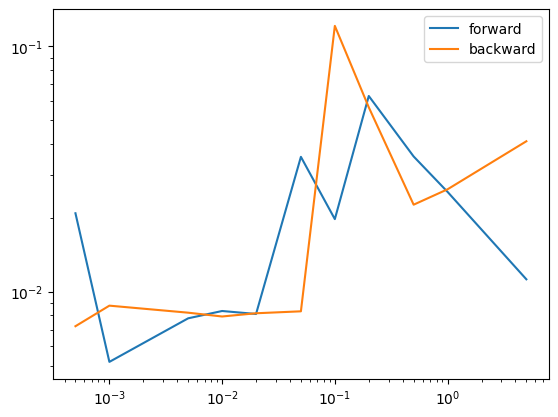

In [17]:
plt.loglog(h_list, errors_fwd, label="forward")
plt.loglog(h_list, errors_bwd, label="backward")
plt.legend()
plt.show()

#### Checking the matching of derivatives in a 2x2 junction

In [18]:
# Create network and run simulation
T = 150
N = 3
speed_limits = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
controls = [[], [], [], []]
cycle = [torch.tensor(60.0), torch.tensor(60.0)]

network = generate.two_two_junction(T, N, speed_limits, controls, cycle, track_grad=True)
densities, queues, lengths, delays, n_stops = network.solve_cons_law_counting()

Bus bus_1 reached bus stop 0 at time 29.928564071655273, should wait for 29.70793914794922 seconds
Bus bus_2 reached bus stop 0 at time 104.71446228027344, should wait for 29.555421829223633 seconds


In [19]:
# Compute gradient
objective_val = delays[0][0] + delays[1][0]
objective_val.backward()

speed_grad = network.get_speed_limit_grads()
light_grad = network.get_traffic_light_grads()
ad_grad = speed_grad + light_grad

In [20]:
ad_grad_scaled = np.array([ad_grad[0]/3.6, ad_grad[1]/3.6, ad_grad[2]/3.6, ad_grad[3]/3.6,
                           ad_grad[4], ad_grad[5]])

In [21]:
ad_grad_scaled

array([-2.04110626e-01, -6.65107303e-01,  1.81416277e-02, -8.01795257e-01,
        4.78045017e-01, -4.72537265e-21])

Estimating using finite differences

In [22]:
# Forward difference
h_list = [30, 20, 15, 10, 5]

objectives_fwd = []
for h in h_list:
    speed_limits_orig = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
    speed_limits_h1 = [[torch.tensor(40.0 + h)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
    speed_limits_h2 = [[torch.tensor(40.0)], [torch.tensor(40.0 + h)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
    speed_limits_h3 = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0 + h)], [torch.tensor(40.0)]]
    speed_limits_h4 = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0 + h)]]
    cycle_orig = [torch.tensor(60.0), torch.tensor(60.0)]
    cycle_h1 = [torch.tensor(60.0 + h), torch.tensor(60.0)]
    cycl_h2 = [torch.tensor(60.0), torch.tensor(60.0 + h)]

    network_1 = generate.two_two_junction(T, N, speed_limits_h1, controls, cycle_orig, track_grad=False)
    network_2 = generate.two_two_junction(T, N, speed_limits_h2, controls, cycle_orig, track_grad=False)
    network_3 = generate.two_two_junction(T, N, speed_limits_h3, controls, cycle_orig, track_grad=False)
    network_4 = generate.two_two_junction(T, N, speed_limits_h4, controls, cycle_orig, track_grad=False)
    network_5 = generate.two_two_junction(T, N, speed_limits_orig, controls, cycle_h1, track_grad=False)
    network_6 = generate.two_two_junction(T, N, speed_limits_orig, controls, cycl_h2, track_grad=False)

    densities_h1, _, _, _, _ = network_1.solve_cons_law_counting()
    densities_h2, _, _, _, _ = network_2.solve_cons_law_counting()
    densities_h3, _, _, _, _ = network_3.solve_cons_law_counting()
    densities_h4, _, _, _, _ = network_4.solve_cons_law_counting()
    densities_h5, _, _, _, _ = network_3.solve_cons_law_counting()
    densities_h6, _, _, _, _ = network_4.solve_cons_law_counting()

    objectives_fwd.append([throughput(network_1, densities_h1), throughput(network_2, densities_h2),
                           throughput(network_3, densities_h3), throughput(network_4, densities_h4),
                           throughput(network_5, densities_h5), throughput(network_6, densities_h6)])


objectives_bwd = []
for h in h_list:
    speed_limits_orig = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
    speed_limits_h1 = [[torch.tensor(40.0 - h)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
    speed_limits_h2 = [[torch.tensor(40.0)], [torch.tensor(40.0 - h)], [torch.tensor(40.0)], [torch.tensor(40.0)]]
    speed_limits_h3 = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0 - h)], [torch.tensor(40.0)]]
    speed_limits_h4 = [[torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0)], [torch.tensor(40.0 - h)]]
    cycle_orig = [torch.tensor(60.0), torch.tensor(60.0)]
    cycle_h1 = [torch.tensor(60.0 - h), torch.tensor(60.0)]
    cycl_h2 = [torch.tensor(60.0), torch.tensor(60.0 - h)]

    network_1 = generate.two_two_junction(T, N, speed_limits_h1, controls, cycle_orig, track_grad=False)
    network_2 = generate.two_two_junction(T, N, speed_limits_h2, controls, cycle_orig, track_grad=False)
    network_3 = generate.two_two_junction(T, N, speed_limits_h3, controls, cycle_orig, track_grad=False)
    network_4 = generate.two_two_junction(T, N, speed_limits_h4, controls, cycle_orig, track_grad=False)
    network_5 = generate.two_two_junction(T, N, speed_limits_orig, controls, cycle_h1, track_grad=False)
    network_6 = generate.two_two_junction(T, N, speed_limits_orig, controls, cycl_h2, track_grad=False)

    densities_h1, _, _, _, _ = network_1.solve_cons_law_counting()
    densities_h2, _, _, _, _ = network_2.solve_cons_law_counting()
    densities_h3, _, _, _, _ = network_3.solve_cons_law_counting()
    densities_h4, _, _, _, _ = network_4.solve_cons_law_counting()
    densities_h5, _, _, _, _ = network_3.solve_cons_law_counting()
    densities_h6, _, _, _, _ = network_4.solve_cons_law_counting()

    objectives_bwd.append([throughput(network_1, densities_h1), throughput(network_2, densities_h2),
                           throughput(network_3, densities_h3), throughput(network_4, densities_h4),
                           throughput(network_5, densities_h5), throughput(network_6, densities_h6)])

Bus bus_1 reached bus stop 0 at time 28.93691635131836, should wait for 29.52756118774414 seconds
Bus bus_2 reached bus stop 0 at time 105.26815032958984, should wait for 29.667781829833984 seconds
Bus bus_1 reached bus stop 0 at time 24.259695053100586, should wait for 29.86117172241211 seconds
Bus bus_2 reached bus stop 0 at time 105.26695251464844, should wait for 29.668739318847656 seconds
Bus bus_1 reached bus stop 0 at time 30.20410919189453, should wait for 29.98574447631836 seconds
Bus bus_2 reached bus stop 0 at time 103.61040496826172, should wait for 29.710363388061523 seconds
Bus bus_1 reached bus stop 0 at time 30.20410919189453, should wait for 29.99038314819336 seconds
Bus bus_2 reached bus stop 0 at time 99.06694030761719, should wait for 29.897550582885742 seconds
Bus bus_1 reached bus stop 0 at time 29.4999942779541, should wait for 29.829423904418945 seconds
Bus bus_2 reached bus stop 0 at time 104.71711730957031, should wait for 29.928937911987305 seconds
Bus bus_1 

In [23]:
derivatives_fwd = []
for h, objective in zip(h_list, objectives_fwd):
    grad1 = (objective[0] - objective_val.detach()) / h
    grad2 = (objective[1] - objective_val.detach()) / h
    grad3 = (objective[2] - objective_val.detach()) / h
    grad4 = (objective[3] - objective_val.detach()) / h
    grad5 = (objective[4] - objective_val.detach()) / h
    grad6 = (objective[5] - objective_val.detach()) / h
    derivatives_fwd.append([grad1, grad2, grad3, grad4, grad5, grad6])


derivatives_bwd = []
for h, objective in zip(h_list, objectives_bwd):
    grad1 = (objective_val.detach() - objective[0]) / h
    grad2 = (objective_val.detach() - objective[1]) / h
    grad3 = (objective_val.detach() - objective[2]) / h
    grad4 = (objective_val.detach() - objective[3]) / h
    grad5 = (objective_val.detach() - objective[4]) / h
    grad6 = (objective_val.detach() - objective[5]) / h
    derivatives_bwd.append([grad1, grad2, grad3, grad4, grad5, grad6])

In [24]:
errors_fwd = [np.linalg.norm(np.array(grad) - ad_grad_scaled) for grad in derivatives_fwd]
errors_bwd = [np.linalg.norm(np.array(grad) - ad_grad_scaled) for grad in derivatives_bwd]

i = 5
errors_fwd = [np.linalg.norm(np.array(grad[i]) - ad_grad_scaled[i]) for grad in derivatives_fwd]
errors_bwd = [np.linalg.norm(np.array(grad[i]) - ad_grad_scaled[i]) for grad in derivatives_bwd]

In [25]:
# derivatives_bwd
errors_fwd = [np.linalg.norm(np.array(grad) - ad_grad_scaled) for grad in derivatives_fwd]
errors_bwd = [np.linalg.norm(np.array(grad) - ad_grad_scaled) for grad in derivatives_bwd]

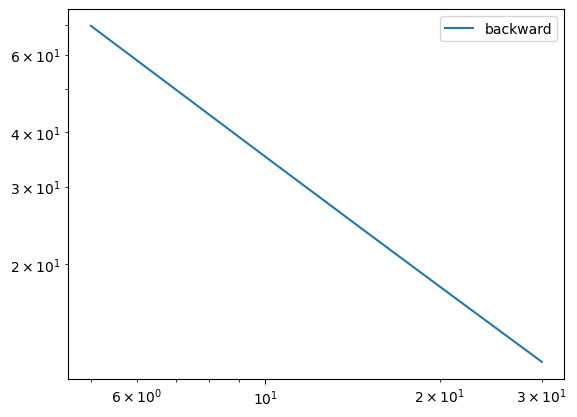

In [26]:
# plt.loglog(h_list, errors_fwd, label="forward")
plt.loglog(h_list, errors_bwd, label="backward")
plt.legend()
plt.show()